# Scenario 3: Causal Reasoning with Interventions

### Load MIRA dependencies

In [1]:
import os
import json
import sympy

from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

from mira.modeling.ode import OdeModel, simulate_ode_model
import numpy
import matplotlib.pyplot as plt

## Build SEIR model

### Define units

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# Define and stratify model concepts

In [3]:
_susceptible = Concept(name='S', units=person_units(), identifiers={'ido': '0000514'})
_exposed = Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'})
_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})
_recovered = Concept(name='R', units=person_units(), identifiers={'ido': '0000592'})

c = {
    'S_y': _susceptible.with_context(status="young"),
    'S_m': _susceptible.with_context(status="middle"),
    'S_o': _susceptible.with_context(status="old"),
    'E_y': _exposed.with_context(status="young"),
    'E_m': _exposed.with_context(status="middle"),
    'E_o': _exposed.with_context(status="old"),
    'I_y': _infected.with_context(status="young"),
    'I_m': _infected.with_context(status="middle"),
    'I_o': _infected.with_context(status="old"),
    'R_y': _recovered.with_context(status="young"),
    'R_m': _recovered.with_context(status="middle"),
    'R_o': _recovered.with_context(status="old"),
}

for concept in c:
    c[concept].name = concept

### Define parameters with uncertainty

In [4]:
# To add a small distribution around parameters (for Terarium)
def unif_distribution_create(value: float):
    return Distribution(
        type="StandardUniform1",
        parameters={"minimum": value, "maximum": value + max(0.01*value,0.1)},
    )

In [5]:
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.2), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.05,
                                                            'maximum': 0.8})),  # Infection rate
    'N': Parameter(name='N', value=sympy.Float(300.0), units=person_units()),  # Total population
    'mew': Parameter(name='mew', value=sympy.Float(0.0), units=per_day_units()),  # Mask efficacy
    'mcw': Parameter(name='mcw', value=sympy.Float(0.0), units=per_day_units()),  # Mask compliance
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.08), units=per_day_units()),  # Rate of progressing E -> I
    'r_IR': Parameter(name='r_IR', value=sympy.Float(0.06), units=per_day_units()),  # Rate of progressing I -> R
    'Myy': Parameter(name='Myy', value=sympy.Float(38.62), units=per_day_units()),  # Contact rate young -> young
    'Mym': Parameter(name='Mym', value=sympy.Float(20.56), units=per_day_units()),  # Contact rate young -> middle
    'Myo': Parameter(name='Myo', value=sympy.Float(6.12), units=per_day_units()),  # Contact rate young -> old
    'Mmy': Parameter(name='Mmy', value=sympy.Float(20.56), units=per_day_units()),  # Contact rate middle -> young
    'Mmm': Parameter(name='Mmm', value=sympy.Float(28.22), units=per_day_units()),  # Contact rate middle -> middle
    'Mmo': Parameter(name='Mmo', value=sympy.Float(11.6), units=per_day_units()),  # Contact rate middle -> old
    'Moy': Parameter(name='Moy', value=sympy.Float(6.12), units=per_day_units()),  # Contact rate old -> young
    'Mom': Parameter(name='Mom', value=sympy.Float(11.6), units=per_day_units()),  # Contact rate old -> middle
    'Moo': Parameter(name='Moo', value=sympy.Float(20.01), units=per_day_units()),  # Contact rate old -> old
}

### Define variables

In [6]:
S_y, S_m, S_o, E_y, E_m, E_o, I_y, I_m, I_o, R_y, R_m, R_o, beta, N, mew, mcw, r_EI, r_IR, Myy, Mym, Myo, Mmy, Mmm, Mmo, Moy, Mom, Moo = \
    sympy.symbols(
        'S_y S_m S_o E_y E_m E_o I_y I_m I_o R_y R_m R_o beta N mew mcw r_EI r_IR Myy Mym Myo Mmy Mmm Mmo Moy Mom Moo'
    )

### Set initial values

In [7]:
initials = {
    "S_y": Initial(concept=c["S_y"], expression=99.0),
    "S_m": Initial(concept=c["S_m"], expression=99.0),
    "S_o": Initial(concept=c["S_o"], expression=99.0),
    "E_y": Initial(concept=c["E_y"], expression=1.0),
    "E_m": Initial(concept=c["E_m"], expression=1.0),
    "E_o": Initial(concept=c["E_o"], expression=1.0),
    "I_y": Initial(concept=c["I_y"], expression=0.0),
    "I_m": Initial(concept=c["I_m"], expression=0.0),
    "I_o": Initial(concept=c["I_o"], expression=0.0),
    "R_y": Initial(concept=c["R_y"], expression=0.0),
    "R_m": Initial(concept=c["R_m"], expression=0.0),
    "R_o": Initial(concept=c["R_o"], expression=0.0),
}

### Define templates

In [8]:
##### S -> E
# Sy -> Ey by Iy
syeyiy = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_y'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Myy*I_y) / N
)
# Sy -> Ey by Im
syeyim = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_m'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Mym*I_m) / N
)
# Sy -> Ey by Io
syeyio = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_o'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Myo*I_o) / N
)

# Sm -> Em by Iy
smemiy = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_y'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmy*I_y) / N
)
# Sm -> Em by Im
smemim = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_m'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmm*I_m) / N
)
# Sm -> Em by Io
smemio = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_o'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmo*I_o) / N
)

# So -> Eo by Iy
soeoiy = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_y'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Moy*I_y) / N
)
# So -> Eo by Im
soeoim = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_m'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Mom*I_m) / N
)
# So -> Eo by Io
soeoio = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_o'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Moo*I_o) / N
)

#### E -> I
# Ey -> Iy
eyiy = NaturalConversion(
    subject=c['E_y'],
    outcome=c['I_y'],
    rate_law=r_EI*E_y
)
# Em -> Im
emim = NaturalConversion(
    subject=c['E_m'],
    outcome=c['I_m'],
    rate_law=r_EI*E_m
)
# Eo -> Io
eoio = NaturalConversion(
    subject=c['E_o'],
    outcome=c['I_o'],
    rate_law=r_EI*E_o
)

#### I -> R
# Iy -> Ry
iyry = NaturalConversion(
    subject=c['I_y'],
    outcome=c['R_y'],
    rate_law=r_IR*I_y
)
# Im -> Rm
imrm = NaturalConversion(
    subject=c['I_m'],
    outcome=c['R_m'],
    rate_law=r_IR*I_m
)
# Io -> Ro
ioro = NaturalConversion(
    subject=c['I_o'],
    outcome=c['R_o'],
    rate_law=r_IR*I_o
)

### Define observables

In [9]:
observables_seir = {
    'susceptible': Observable(name='susceptible', expression=S_y+S_m+S_o),
    'exposed': Observable(name='exposed', expression=E_y+E_m+E_o),
    'infected': Observable(name='infected', expression=I_y+I_m+I_o),
    'recovered': Observable(name='recovered', expression=R_y+R_m+R_o),
}

### Define template model and save as petrinet AMR

In [10]:
seir_model = TemplateModel(
    templates=[
        syeyiy,
        syeyim,
        syeyio,
        smemiy,
        smemim,
        smemio,
        soeoiy,
        soeoim,
        soeoio,
        eyiy,
        emim,
        eoio,
        iyry,
        imrm,
        ioro,
    ],
    parameters=parameters,
    initials=initials,
    observables=observables_seir
)

# Save as JSON
with open("SEIR_scenario3_petrinet.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

In [11]:
om = OdeModel(model=Model(seir_model), initialized=True)

In [12]:
times_test = numpy.linspace(0, 100, 100)
res = simulate_ode_model(ode_model=om, times=times_test,
                                 with_observables=True)



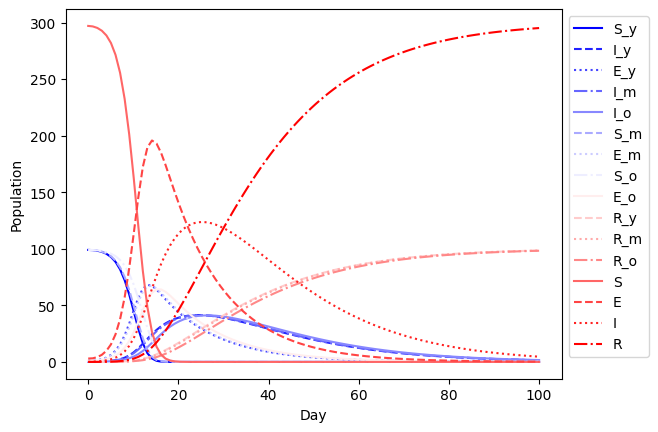

In [13]:
#variable_list=list(seir_model.initials.keys())
variable_list = ['S_y', 'I_y', 'E_y', 'I_m', 'I_o', 'S_m', 'E_m', 'S_o', 'E_o', 'R_y', 'R_m', 'R_o', 'S', 'E', 'I', 'R']
cm = plt.cm.bwr(numpy.linspace(0, 1, len(variable_list))) # can also use: bwr, brg, hsv, jet
ax = plt.subplot(111)
marker_list = ['-','--',':','-.']*4
ax.set_prop_cycle(color=list(cm), linestyle=marker_list)


ax.legend(handles = plt.plot(times_test,res), labels=variable_list,loc = 'upper left', bbox_to_anchor=(1,1))
plt.xlabel('Day')
plt.ylabel('Population')
plt.show()

## Change parameter values and uncertainty from the AMR

In [14]:
filename = "SEIR_scenario3_petrinet.json"
with open(filename, 'r') as fh:
    tm = template_model_from_amr_json(json.load(fh))

# Change `Myy` parameter value
tm.parameters["Myy"].value = 50.0

# Change `Myy` distribution
tm.parameters["Myy"].distribution = Distribution(type='StandardUniform1',
                                                 parameters={'minimum': 40.0, 'maximum': 80.0})

# Save as updated AMR
with open('update_parameters_example.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm), fh, indent=1)